In [1]:
### --- Libraries --- ###
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import datetime as dt

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [4]:
file_name = './data/data_000637.txt'
# save complete dataset
all_data = pd.read_csv(file_name)
# generate random number between 10k and maximum number of rows
N = np.random.randint(1e04,len(all_data))
print('Number of rows N is:',N)
# save dataset with N rows
data = pd.read_csv(file_name, nrows = N)
data

Number of rows N is: 205677


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
205672,1,0,62,3869202214,356,6
205673,1,0,63,3869202214,361,9
205674,1,0,35,3869202214,393,26
205675,1,0,62,3869202214,395,25


2\. Estimate the number of BX in a ORBIT (the value 'x').

In [13]:
# find maxmimum value in column BX_COUNTER
m = data['BX_COUNTER'].max()
print("Maximum is",m)
# print the first 5 rows that correspond to the maximum value of BX_COUNTER
print(data[data['BX_COUNTER'] == m].head())
print("\nIf the values of TDC_MEAS corresponding to the max values of BX_COUNTER are not zero, the value of BX_COUNTER for which ORBIT_CNT is increased by one unit (x) is equal to m+1")
x = m + 1
print("\n --> x =", x)

Maximum is 3563
      HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS       TIME_ns
2893     1     0           45  3869200195        3563        29  3.447457e+14
4073     1     0          122  3869200207        3563        22  3.447457e+14
4461     1     0          124  3869200211        3563         6  3.447457e+14
4745     1     1           27  3869200214        3563         3  3.447457e+14
4747     1     1           28  3869200214        3563        10  3.447457e+14

If the values of TDC_MEAS corresponding to the max values of BX_COUNTER are not zero, the value of BX_COUNTER for which ORBIT_CNT is increased by one unit (x) is equal to m+1

 --> x = 3564


3\. Find out the duration of the data taking in hours, minutes and seconds. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading the whole dataset.

In [14]:
def conversion(data):
    '''
        Convert data from a.u. to nanoseconds 
    '''
    t = data['TDC_MEAS']*25/30 + 25*data['BX_COUNTER'] + 3564*25*data['ORBIT_CNT'] 
    return t

# we use the complete dataset to estimate the duration of data taking 
time = conversion(all_data)
tot_time = time.max() - time.min()

print('The data taking lasted', tot_time*1e-9, 'seconds')


The data taking lasted 0.9804162533125 seconds


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition.

In [17]:
data['TIME_ns'] = data['TDC_MEAS']*25/30 + 25*data['BX_COUNTER'] + 3564*25*data['ORBIT_CNT']
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_ns
0,1,0,123,3869200167,2374,26,3.447457e+14
1,1,0,124,3869200167,2374,27,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14
...,...,...,...,...,...,...,...
205672,1,0,62,3869202214,356,6,3.447459e+14
205673,1,0,63,3869202214,361,9,3.447459e+14
205674,1,0,35,3869202214,393,26,3.447459e+14
205675,1,0,62,3869202214,395,25,3.447459e+14


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [9]:
noise = data.groupby('TDC_CHANNEL').TDC_CHANNEL.count().nlargest(3)

noise2 = data.groupby('TDC_CHANNEL').count().sort_values('HEAD', ascending=False)


print('1st method:\n',noise)
print('\n2nd method:\n',noise2.head(3))

1st method:
 TDC_CHANNEL
139    17098
64     10198
63      9974
Name: TDC_CHANNEL, dtype: int64

2nd method:
               HEAD   FPGA  ORBIT_CNT  BX_COUNTER  TDC_MEAS  TIME_ns
TDC_CHANNEL                                                        
139          17098  17098      17098       17098     17098    17098
64           10198  10198      10198       10198     10198    10198
63            9974   9974       9974        9974      9974     9974


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit). Count also the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [18]:
# hit = entry in the data frame 
ORBITgroup = data.groupby("ORBIT_CNT")
print("non-empty orbits: ", len(ORBITgroup))

group139 = data[data["TDC_CHANNEL"]==139].groupby("ORBIT_CNT")
print("unique orbits with at least one TDC_channel = 139: ", len(group139))



non-empty orbits:  2045
unique orbits with at least one TDC_channel = 139:  2042


7\. **Optional:** Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

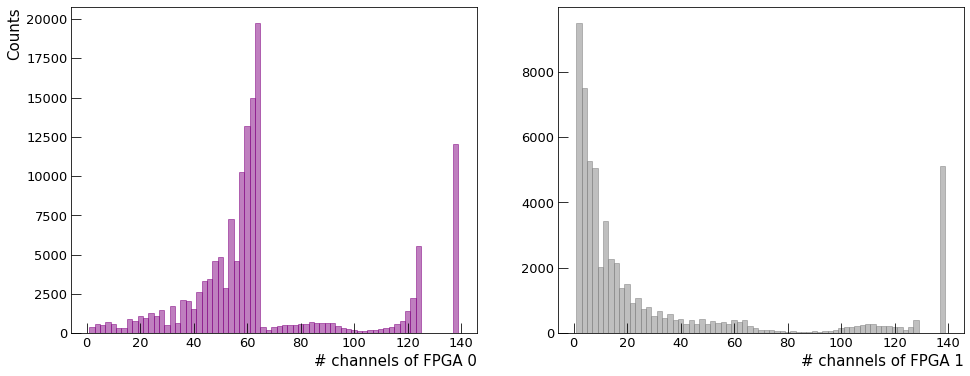

In [12]:
# FPGA and TDC channel identify the sensor that has recorded the signal

data0 = data[data.FPGA != 1]
data1 = data[data.FPGA != 0]

n0 = data0.loc[:,'TDC_CHANNEL'].max()
n1 = data1.loc[:,'TDC_CHANNEL'].max()

# Plot counts for each channel
fig,((ax0,ax1)) = plt.subplots(1,2,figsize=(16,6))
ax0.hist(data0.loc[:,'TDC_CHANNEL'], bins = n0//2, alpha=0.5, color='purple',edgecolor='purple')
ax1.hist(data1.loc[:,'TDC_CHANNEL'], bins = n1//2, alpha=0.5, color='grey',edgecolor='grey')
ax0.set_ylabel('Counts',fontsize = 15, loc = 'top')
ax0.set_xlabel('# channels of FPGA 0', fontsize = 15, loc = 'right')
ax1.set_xlabel('# channels of FPGA 1',fontsize = 15, loc = 'right')

for ax in fig.get_axes():
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10,labelsize = 13)
    
plt.show()